In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 5.7 MB/s 
     |████████████████████████████████| 407 kB 36.4 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=b9c6e2faa03544b222d2f82aecd76a899ac78940b4882f80797ac4829b1a0d1b
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


In [4]:
import json
import pandas as pd
import time
import networkx as nx
from torch_geometric.utils import from_networkx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCN
from torch.utils.data import Dataset, DataLoader

In [5]:
nx_graph = nx.read_gml('graph_with_features.gml')
G = from_networkx(nx_graph, group_node_attrs=['out_degree', 'in_degree', 'category_multi_hot', 'article_embed'])

path_data = pd.read_csv('data_by_index.tsv', sep='\t', header=None)

In [25]:
def get_evaluation_metrics(device, dataloader, dataset_size):
    model.eval()
    avg_loss = 0
    num_correct = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # get data
            inputs, labels = data['indices'].to(device), data['label'].to(device)
            outputs = model(inputs)
            # get loss
            loss = F.nll_loss(outputs, labels)
            avg_loss += loss.item()
            # get accuracy
            pred = outputs.argmax(dim=1)
            correct = (pred == labels).sum()
            num_correct += correct
    acc = int(num_correct) / dataset_size
    avg_loss /= dataset_size
    return acc, avg_loss

In [52]:
class CustomPathDataset(Dataset):
    def __init__(self, path_data):
        self.x = path_data[0].apply(json.loads)
        self.labels = path_data[1]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.LongTensor(self.x[idx])
        label = self.labels[idx]
        sample = {"indices": x, "label": label}
        return sample

In [53]:
class Model(torch.nn.Module):
    def __init__(self, graph, device, gnn_hidden_size=128, node_embed_size=64, lstm_hidden_size=32):
        super().__init__()
        self.graphX = graph.x.to(device)
        self.graphEdgeIndex = graph.edge_index.to(device)
        self.gcn = GCN(in_channels=self.graphX.shape[1], 
                       hidden_channels=gnn_hidden_size, 
                       num_layers=3, 
                       out_channels=node_embed_size, 
                       dropout=0.1)
        self.lstm_input_size = node_embed_size
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            batch_first=True)
        self.pred_head = nn.Linear(lstm_hidden_size, self.graphX.shape[0])

    def forward(self, indices):
        node_emb = self.gcn(self.graphX, self.graphEdgeIndex)
        node_emb_with_padding = torch.cat([node_emb, torch.zeros((1, self.lstm_input_size)).to(device)])
        paths = node_emb_with_padding[indices]
        out, _ = self.lstm(paths)
        predictions = self.pred_head(torch.sum(out, dim=1))
        return F.log_softmax(predictions, dim=1)

In [1]:
# set up our model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(G, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# get our dataset + splits
dataset = CustomPathDataset(path_data)
train_size = int(0.9 * len(dataset))
test_size = int(0.05 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# set up for training + validation
batch_size = 1024
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

NameError: ignored

In [ ]:
best_acc = 0
training_losses = []
validation_losses = []
validation_accs = []
for epoch in range(200):  # loop over the dataset multiple times
    for name, param in model.named_parameters():
        if name == "gcn.convs.0.lin.weight":
            print(name, param.data)
    print('Epoch:', epoch+1)
    model.train()
    epoch_loss = 0
    start_time = time.time()
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['indices'].to(device), data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    # validate epoch and print results
    training_losses.append(epoch_loss / train_size)
    print('Training Loss:', training_losses[-1])
    acc, valid_loss = get_evaluation_metrics(device, validloader, val_size)
    validation_losses.append(valid_loss)
    validation_accs.append(acc)
    if acc > best_acc:
        torch.save(model.state_dict(), "model_weights_12_06.pth")
        best_acc = acc
    print("Validation accuracy:", acc)
    print("Validation loss:", valid_loss)
    print('Time elapsed:', time.time() - start_time)
    print()

gcn.convs.0.lin.weight tensor([[ 1.1404e-01,  1.0253e-02,  1.0133e-01,  ...,  6.5041e-02,
          2.4902e-02, -4.1059e-02],
        [-1.7127e-01, -1.0838e-02, -1.6246e-01,  ..., -1.5994e-02,
         -3.1946e-02,  3.1374e-02],
        [ 8.1365e-02,  4.1903e-02,  1.1786e-03,  ...,  5.7412e-03,
         -4.1093e-05, -2.7918e-02],
        ...,
        [-1.7480e-01, -1.3352e-02, -2.0479e-01,  ..., -2.6853e-02,
          2.6880e-02, -2.6261e-02],
        [ 1.5993e-01, -2.1970e-02,  1.5705e-01,  ...,  1.2746e-01,
          9.4680e-03,  9.3174e-03],
        [-5.8447e-02, -2.9991e-02, -4.8957e-02,  ...,  6.9725e-03,
          2.4767e-02,  2.7573e-02]], device='cuda:0')
Epoch: 1
Training Loss: 0.008432293669698184
Validation accuracy: 0.01949317738791423
Validation loss: 0.00921744166294269
Time elapsed: 4.86078405380249

gcn.convs.0.lin.weight tensor([[-0.0088,  0.0014, -0.0046,  ..., -0.0022,  0.0045,  0.0040],
        [-0.0309,  0.0004, -0.0660,  ...,  0.0236, -0.0062, -0.0046],
        [-

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14d66c6dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

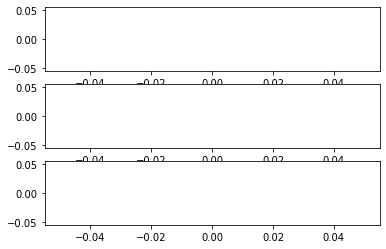

In [46]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(311)
plt.plot(training_losses)
plt.subplot(312)
plt.plot(validation_losses)
plt.subplot(313)
plt.plot(validation_accs)